In [1]:
import tarfile
tar = tarfile.open('100.tar', "r:")
tar.extractall()

In [5]:
import os
import cv2
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [8]:
# For dcm
dcmpixel=[]
for i in serialNo:
    j=i.replace('jpg', 'dcm')
    filepath='/home/hihipch/SkullSegmentation/dicom/'+j
    pixel = pydicom.filereader.dcmread(filepath).pixel_array
    resizepixel = cv2.resize(pixel, (960, 1280))
    mean, std = resizepixel.mean(), resizepixel.std()
    dcmpixel.append((np.clip((resizepixel-mean)/std, -2.0, 2.0)+2.0)/4.0)
    
jpg100_path = '/home/hihipch/SkullSegmentation/100/jpgfile'
jpg100_list = []
for (path, dir, files) in os.walk(jpg100_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.jpg':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            jpg100_list.append(filePath)
jpg100_list=sorted(jpg100_list)
for i in jpg100_list:
    img = Image.open(i).convert('L')
    image = np.array(img, 'uint8')
    resizeimage = cv2.resize(image, (960, 1280))
    mean, std = resizeimage.mean(), resizeimage.std()
    dcmpixel.append((np.clip((resizeimage-mean)/std, -2.0, 2.0)+2.0)/4.0)
train_imgs=np.array(dcmpixel)
train_imgs = np.reshape(train_imgs, (*train_imgs.shape, 1))

In [9]:
train_imgs.shape

(150, 1280, 960, 1)

(1280, 960)


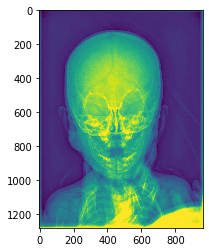

In [10]:
print(dcmpixel[1].shape)
plt.imshow(dcmpixel[100])

In [11]:
# For mask
mask_path = '/home/hihipch/SkullSegmentation/mask' 
mask_list = []
for (path, dir, files) in os.walk(mask_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.jpg':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            mask_list.append(filePath)
mask_list=sorted(mask_list)
mask100_path = '/home/hihipch/SkullSegmentation/100/mask' 
mask100_list = []
for (path, dir, files) in os.walk(mask100_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.jpg':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            mask100_list.append(filePath)
mask100_list=sorted(mask100_list)

In [12]:
maskpixel=[]
for i in mask_list:
    img = Image.open(i).convert('L')
    image = np.array(img, 'uint8')
    resizeimage = cv2.resize(image, (960, 1280))
    mean, std = resizeimage.mean(), resizeimage.std()
    maskpixel.append((np.clip((resizeimage-mean)/std, -2.0, 2.0)+2.0)/4.0)
for i in mask100_list:
    img = Image.open(i).convert('L')
    image = np.array(img, 'uint8')
    resizeimage = cv2.resize(image, (960, 1280))
    mean, std = resizeimage.mean(), resizeimage.std()
    maskpixel.append((np.clip((resizeimage-mean)/std, -2.0, 2.0)+2.0)/4.0)

In [13]:
train_masks = np.array(maskpixel)
train_masks = np.reshape(train_masks, (*train_masks.shape, 1))

In [14]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model

inputs = Input((1280, 960, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1280, 960, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 1280, 960, 1) 4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 1280, 960, 32 320         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 1280, 960, 32 9248        conv2d_20[0][0]                  
____________________________________________________________________________________________

In [15]:
from keras import backend as K
from keras.losses import binary_crossentropy

SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
from keras.optimizers import Adam
model.compile(Adam(lr=1e-4),
              bce_dice_loss,
              metrics=[binary_crossentropy, dice_coef])

In [24]:
model.fit(train_imgs[:130], train_masks[:130], batch_size=2, epochs=200, validation_data=(train_imgs[130:], train_masks[130:]))

Train on 130 samples, validate on 20 samples
Epoch 1/200
130/130 [==============================] - 42s 322ms/step - loss: -0.3445 - binary_crossentropy: 0.5760 - dice_coef: 0.6325 - val_loss: -0.3530 - val_binary_crossentropy: 0.5727 - val_dice_coef: 0.6394
Epoch 2/200
130/130 [==============================] - 46s 351ms/step - loss: -0.3452 - binary_crossentropy: 0.5746 - dice_coef: 0.6326 - val_loss: -0.3501 - val_binary_crossentropy: 0.5760 - val_dice_coef: 0.6381
Epoch 3/200
130/130 [==============================] - 46s 351ms/step - loss: -0.3457 - binary_crossentropy: 0.5745 - dice_coef: 0.6329 - val_loss: -0.3534 - val_binary_crossentropy: 0.5722 - val_dice_coef: 0.6395
Epoch 4/200
130/130 [==============================] - 46s 352ms/step - loss: -0.3460 - binary_crossentropy: 0.5735 - dice_coef: 0.6327 - val_loss: -0.3508 - val_binary_crossentropy: 0.5871 - val_dice_coef: 0.6444
Epoch 5/200
130/130 [==============================] - 46s 351ms/step - loss: -0.3451 - binary_cros

In [18]:
# for test dicom files

test_path = '/home/hihipch/SkullSegmentation/test' 
test_list = []
for (path, dir, files) in os.walk(test_path):
    for filename in files:
        ext = os.path.splitext(filename)[-1]
        if ext == '.dcm':
            filePath = "{0}/{1}".format(path, filename)
            # print(filePath)
            test_list.append(filePath)

testpixel=[]
for i in test_list:
    pixel = pydicom.filereader.dcmread(i).pixel_array
    resizepixel = cv2.resize(pixel, (960, 1280))
    mean, std = resizepixel.mean(), resizepixel.std()
    testpixel.append((np.clip((resizepixel-mean)/std, -2.0, 2.0)+2.0)/4.0)
test_imgs=np.array(testpixel)
test_imgs = np.reshape(test_imgs, (*test_imgs.shape, 1))

In [19]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [20]:
np.reshape(model.predict(test_imgs)[1], (1280, 960))

array([[0.48723662, 0.47589502, 0.46415454, ..., 0.47449726, 0.44576386,
        0.45974407],
       [0.5172299 , 0.4993196 , 0.49903995, ..., 0.49474233, 0.44186553,
        0.41150934],
       [0.5258719 , 0.51064754, 0.5179532 , ..., 0.56391317, 0.47007242,
        0.44547838],
       ...,
       [0.50452644, 0.4729499 , 0.48631167, ..., 0.51751894, 0.42678875,
        0.3759371 ],
       [0.49047774, 0.45525688, 0.4541367 , ..., 0.52018607, 0.431634  ,
        0.41036624],
       [0.49766403, 0.4555625 , 0.44955617, ..., 0.47971603, 0.44005817,
        0.42333183]], dtype=float32)

In [21]:
test_paths = sorted(glob('/home/hihipch/SkullSegmentation/test/*.jpg'))

NameError: name 'glob' is not defined

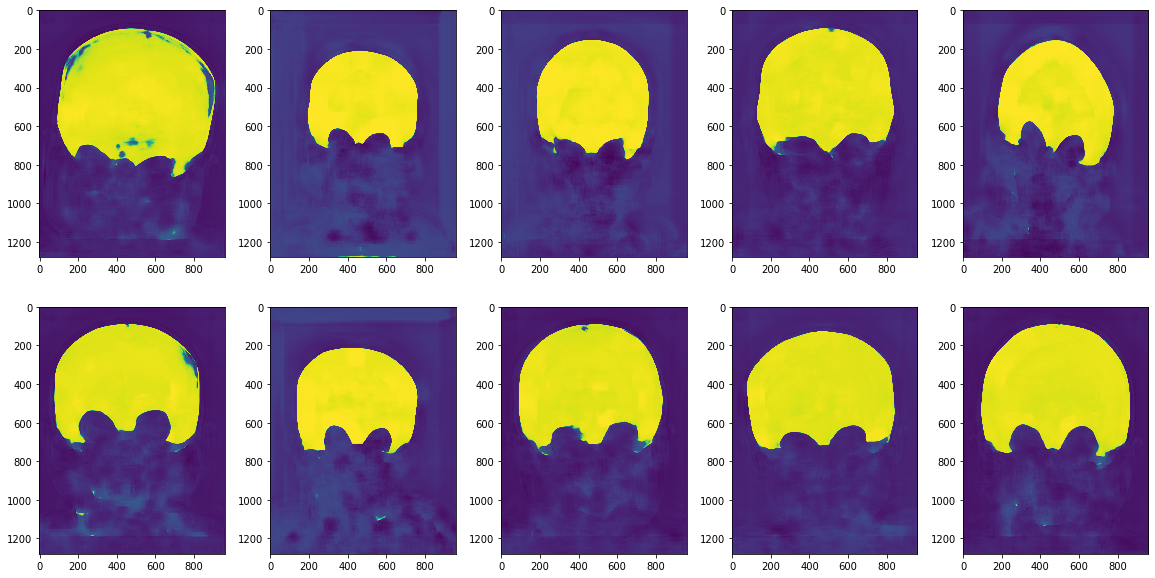

In [25]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(2, 5, 1)
plt.imshow(np.reshape(model.predict(test_imgs)[0], (1280, 960)))
fig.add_subplot(2, 5, 2)
plt.imshow(np.reshape(model.predict(test_imgs)[1], (1280, 960)))
fig.add_subplot(2, 5, 3)
plt.imshow(np.reshape(model.predict(test_imgs)[2], (1280, 960)))
fig.add_subplot(2, 5, 4)
plt.imshow(np.reshape(model.predict(test_imgs)[3], (1280, 960)))
fig.add_subplot(2, 5, 5)
plt.imshow(np.reshape(model.predict(test_imgs)[4], (1280, 960)))
fig.add_subplot(2, 5, 6)
plt.imshow(np.reshape(model.predict(test_imgs)[5], (1280, 960)))
fig.add_subplot(2, 5, 7)
plt.imshow(np.reshape(model.predict(test_imgs)[6], (1280, 960)))
fig.add_subplot(2, 5, 8)
plt.imshow(np.reshape(model.predict(test_imgs)[7], (1280, 960)))
fig.add_subplot(2, 5, 9)
plt.imshow(np.reshape(model.predict(test_imgs)[8], (1280, 960)))
fig.add_subplot(2, 5, 10)
plt.imshow(np.reshape(model.predict(test_imgs)[9], (1280, 960)))

In [26]:
seg0=np.reshape(model.predict(test_imgs)[0], (1280, 960))
seg1=np.reshape(model.predict(test_imgs)[1], (1280, 960))
seg2=np.reshape(model.predict(test_imgs)[2], (1280, 960))
seg3=np.reshape(model.predict(test_imgs)[3], (1280, 960))
seg4=np.reshape(model.predict(test_imgs)[4], (1280, 960))
seg5=np.reshape(model.predict(test_imgs)[5], (1280, 960))
seg6=np.reshape(model.predict(test_imgs)[6], (1280, 960))
seg7=np.reshape(model.predict(test_imgs)[7], (1280, 960))
seg8=np.reshape(model.predict(test_imgs)[8], (1280, 960))
seg9=np.reshape(model.predict(test_imgs)[9], (1280, 960))

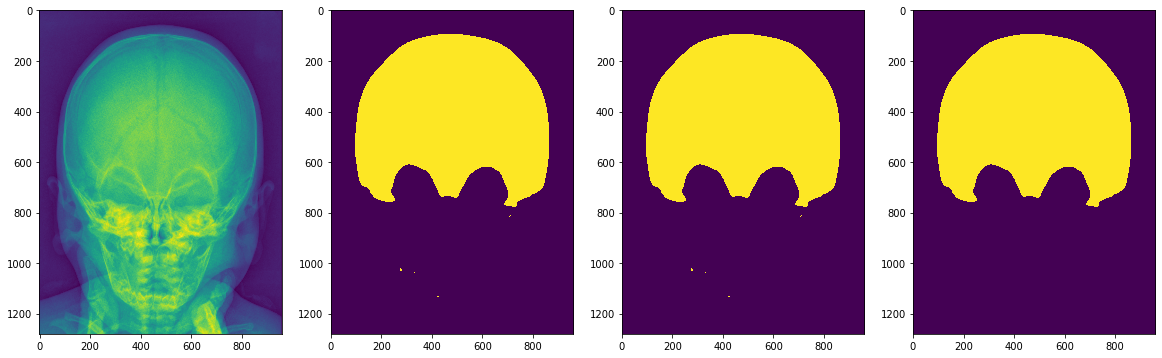

In [196]:
i=9
seg=np.reshape(model.predict(test_imgs)[i], (1280, 960))
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 4, 1)
plt.imshow(np.reshape(test_imgs[i], (1280, 960)))
fig.add_subplot(1, 4, 2)
seg[seg <= 0.7] = 0
seg[seg > 0.7] = 1
plt.imshow(seg)
fig.add_subplot(1, 4, 3)
img_fill_holes = ndimage.binary_fill_holes(seg[:,:]).astype(int)
plt.imshow(img_fill_holes)
fig.add_subplot(1, 4, 4)
img_fill_holes = np.uint8(img_fill_holes)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_fill_holes, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size = 1000
img2 = np.zeros((output.shape))
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255
plt.imshow(img2)

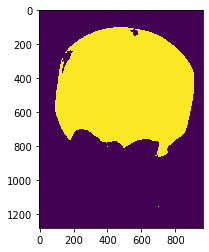

In [119]:
import cv2 
from PIL import Image
import numpy as np
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed

In [126]:
darker = cv2.equalizeHist(seg)

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/histogram.cpp:3429: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


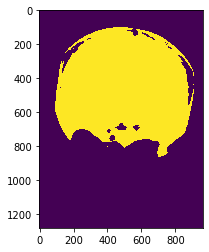

In [132]:
plt.imshow(seg)

In [143]:
n=100
im = ndimage.gaussian_filter(seg, sigma=l/(4.*n))
open_img = ndimage.binary_opening(im)
close_img = ndimage.binary_closing(open_img)

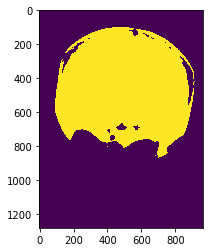

In [144]:
plt.imshow(close_img)